In [1]:
device = 'cpu'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm
from ema_pytorch import EMA


In [3]:
train_dataset = torchvision.datasets.ImageFolder("data/celeba_hq/train", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()
]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder("data/celeba_hq/val", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()
]))

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)


In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 128, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 3, 1, 1),
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
model = Model().to(device)
criterion = nn.MSELoss(reduction='sum')


In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [25]:
ema = EMA(model, beta=0.9999, update_every=1)


In [26]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
])


In [27]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0
    total = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(tqdm.tqdm(val_loader)):
            xs = transform(x)
            
            x = x.to(device)
            xs = xs.to(device)
            
            y = model(xs)
            loss = criterion(y, x)
            total_loss += loss.item()
            total += 1
    
    return total_loss / total


In [28]:
for epoch in range(10):
    model.train()
    with tqdm.tqdm(train_loader) as t:
        for i, (x, _) in enumerate(t):
            xs = transform(x)
            
            x = x.to(device)
            xs = xs.to(device)
            
            y = model(xs)
            loss = criterion(y, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            t.set_postfix_str(f"loss: {loss.item()}, est acc: {torch.exp(-loss).item()}")
            
            ema.update()
        
    val_loss = evaluate(val_loader)
    print(f"val loss: {val_loss}")
    
    # torch.save(model.state_dict(), f"model_{epoch}.pt")


  1%|          | 13/1750 [00:18<42:00,  1.45s/it, loss: 68737.921875, est acc: 0.0] 


KeyboardInterrupt: 

In [29]:
# Print gradients
for name, param in model.named_parameters():
    print(param.grad.mean(), name)


tensor(308.0592) layers.0.weight
tensor(3770.1843) layers.0.bias
tensor(-237.9850) layers.1.weight
tensor(125.9416) layers.1.bias
tensor(-63.9622) layers.4.weight
tensor(-254.1557) layers.4.bias
tensor(-235.7309) layers.5.weight
tensor(235.1641) layers.5.bias
tensor(110.7243) layers.8.weight
tensor(626.5357) layers.8.bias
tensor(-164.8256) layers.9.weight
tensor(139.1480) layers.9.bias
tensor(1516.7977) layers.12.weight
tensor(2462.0747) layers.12.bias
tensor(-3429.5996) layers.13.weight
tensor(27851.3105) layers.13.bias


In [ ]:
print(evaluate(val_loader))


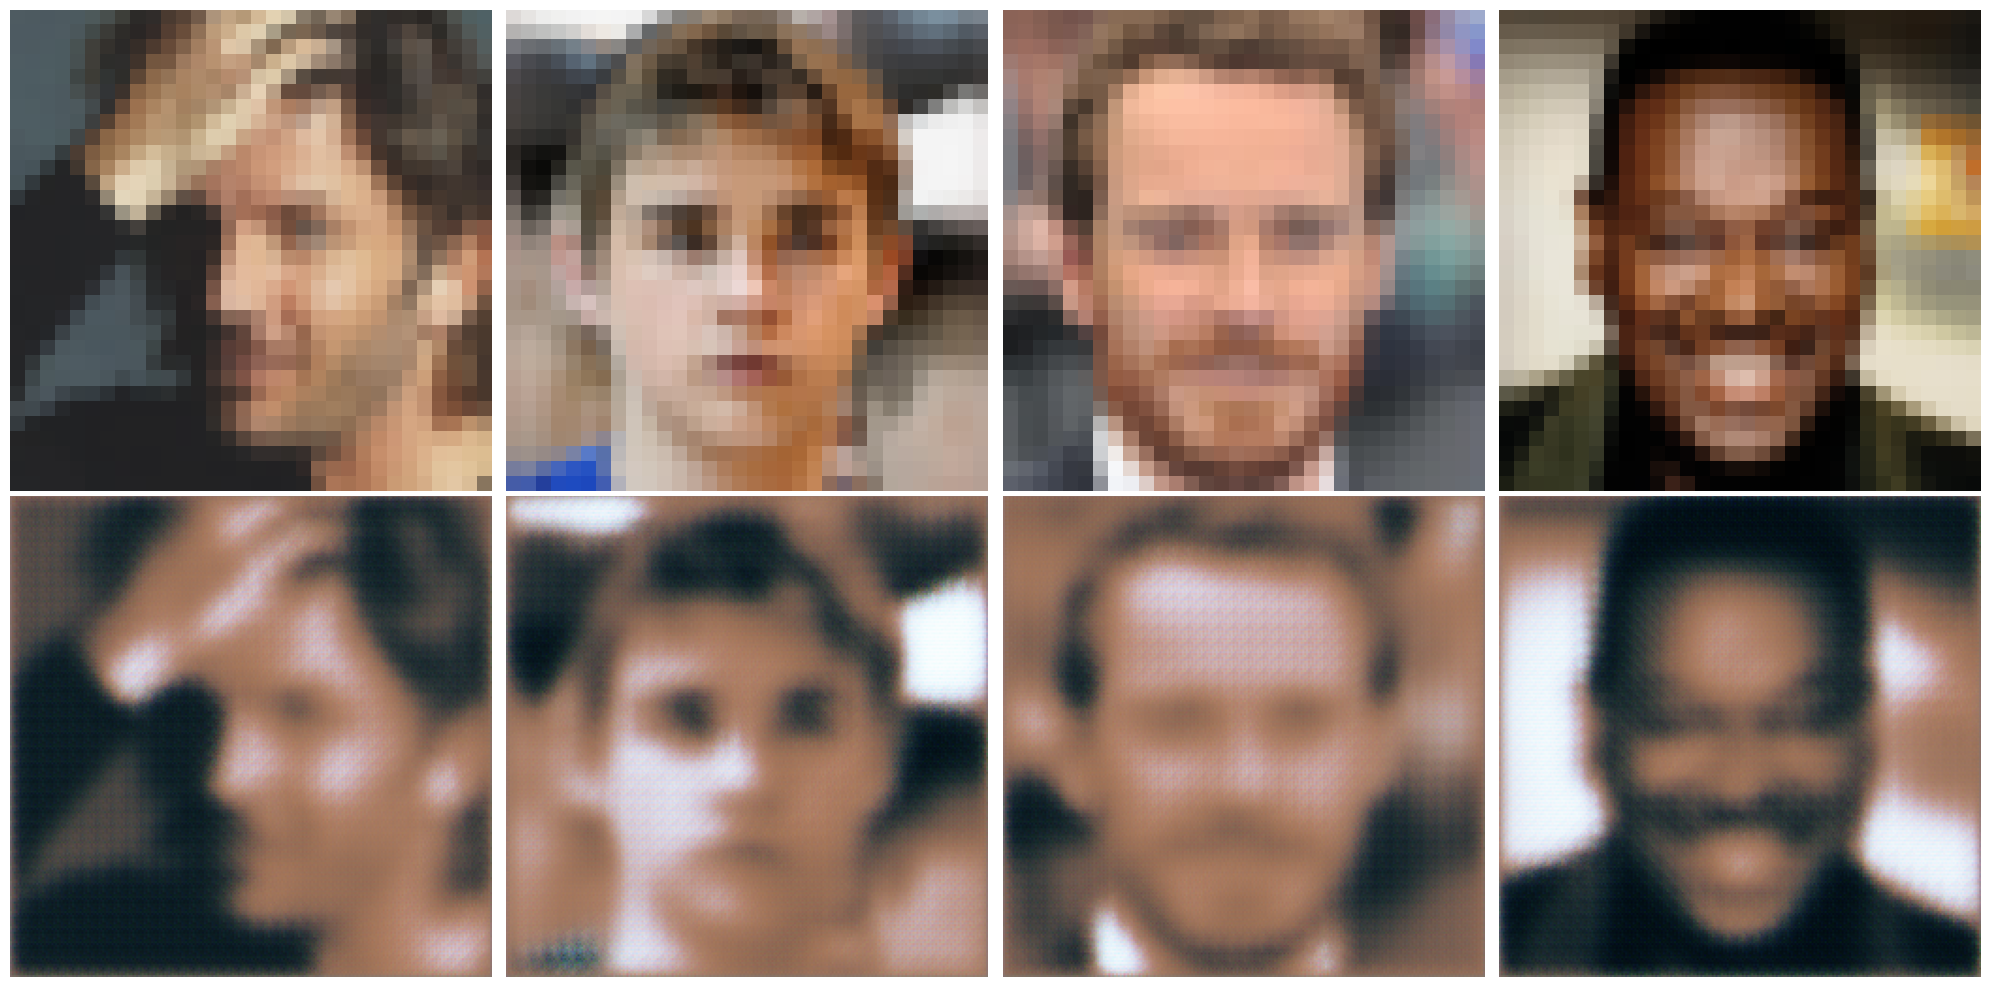

In [22]:
import matplotlib.pyplot as plt

with torch.no_grad():
    x = next(iter(val_loader))[0]
    xs = transform(x)
    xs = xs.to(device)
    y = model(xs)

    plt.figure(figsize=(20, 10))
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(xs[i].permute(1, 2, 0).cpu())
        plt.axis("off")
        
        plt.subplot(2, 4, i + 5)
        plt.imshow(y[i].permute(1, 2, 0).detach().cpu())
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()
